# Particle Motion in a Magnetic Mirror

This notebook simulates the trajectory of a charged particle in a magnetic
mirror configuration formed by two magnetic dipoles.

**Numerical Method:** Euler Method

**Quantities analyzed:**
- Particle trajectory
- Magnetic moment
- Kinetic energy


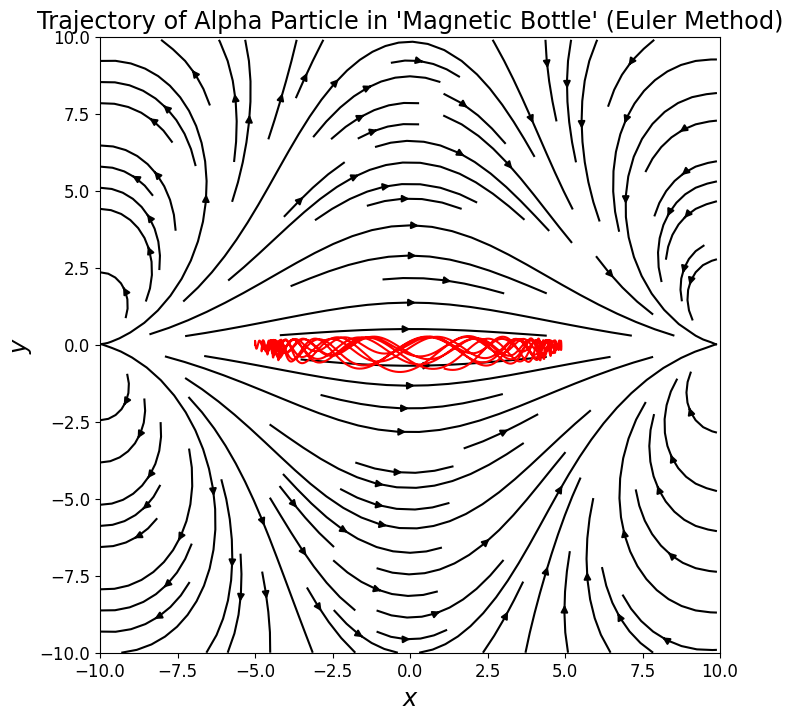

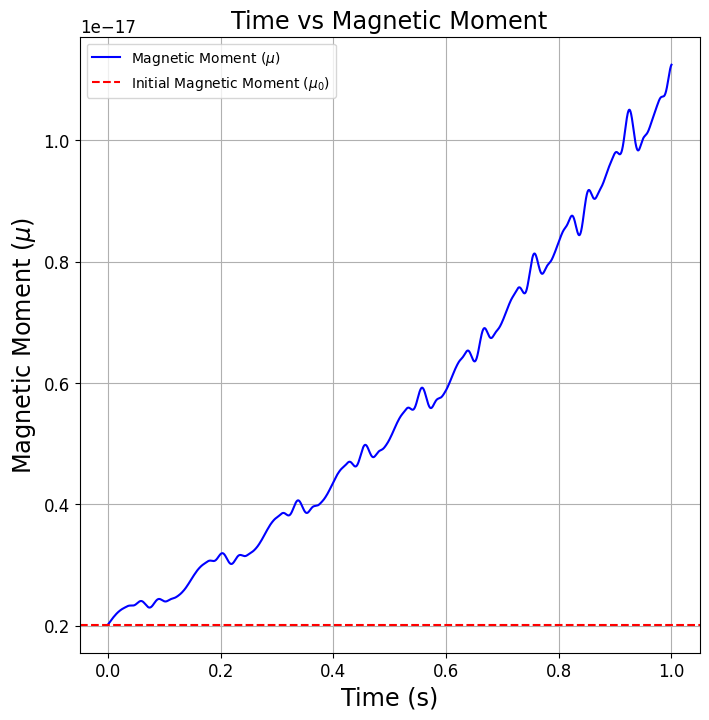

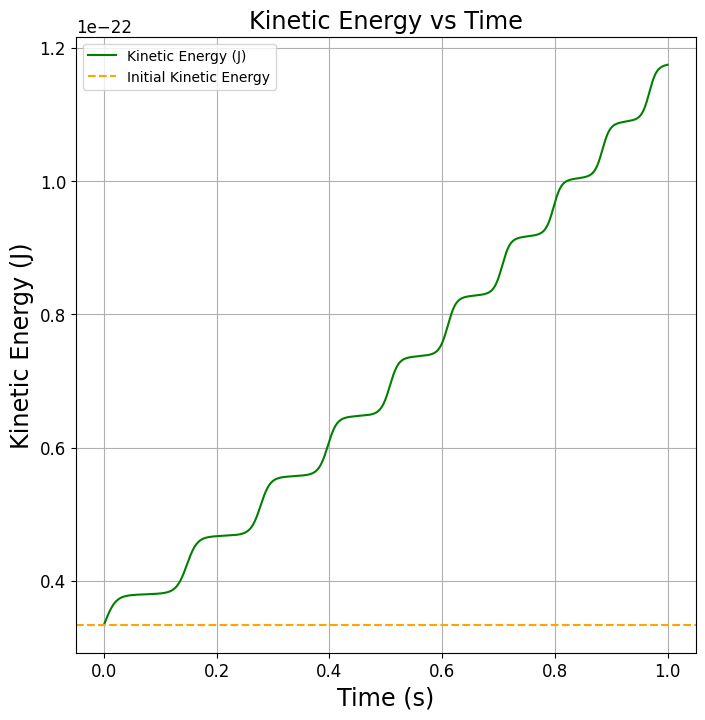

In [ ]:
import numpy
import matplotlib.pyplot as mpl
from numba import jit

# font size of x axis tick label, y axis tick label, x axis label, y axis label, title and figure size
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

# Value of constants (mass of proton(kg), charge of proton(C), permeability of free space(H/m), magnetic moment(J/T))
m_p = 1.67E-27
qe = 1.602E-19
mu0 = numpy.pi * 4.0E-7
mu = 10000.0 * numpy.array([1.0, 0.0, 0.0])  # along x axis

@jit # Just-in-Time compilation

## calculating magnetic field at a point (x,y,z)
def B_field(x, y, z):
    xdisp = 10.0  # Displacement

    # Point dipole A
    posA = numpy.array([xdisp, 0.0, 0.0]) # position vector of dipole A
    rA = numpy.array([x, y, z]) - posA # distance between the dipole A and the point where magnetic field to be calculated
    rmagA = numpy.linalg.norm(rA) # magnitude of the distance
    B1A = 3.0 * rA * numpy.dot(mu, rA) / (rmagA**5)
    B2A = -1.0 * mu / (rmagA**3)

    # Point dipole B
    posB = numpy.array([-xdisp, 0.0, 0.0]) # position vector of dipole B
    rB = numpy.array([x, y, z]) - posB # distance between the dipole B and the point where magnetic field to be calculated
    rmagB = numpy.linalg.norm(rB)
    B1B = 3.0 * rB * numpy.dot(mu, rB) / (rmagB**5)
    B2B = -1.0 * mu / (rmagB**3)

    return (mu0 / (4.0 * numpy.pi)) * (B1A + B2A + B1B + B2B) # formula for magnetic field due to both magnetic dipoles


## calculating parallel and perpendicuar component of velocity and magnetic moment
def parallel_perpendicular_components(v, B):
    B_hat = B / numpy.linalg.norm(B) # unit vector of magnetic field
    v_parallel = numpy.dot(v, B_hat) * B_hat
    v_perp = v - v_parallel
    magnetic_moment = (m * numpy.linalg.norm(v_perp)**2) / (2 * numpy.linalg.norm(B))
    return v_parallel, v_perp, magnetic_moment

## Creating a grid in XY plane
x = numpy.arange(-10.0, 10.0, 0.1)
y = numpy.arange(-10.0, 10.0, 0.1)
X, Y = numpy.meshgrid(x, y) # X(and Y) contains the x-coordinates(and y-coordinates) for all points in the grid
ilen, jlen = numpy.shape(X) # number of rows(ilen) and column(jlen) in X(same as Y)
Bf = numpy.zeros((ilen, jlen, 3)) # initializing 3D array (3 magnetic components)

for i in range(ilen):
    for j in range(jlen):
        Bf[i, j] = B_field(X[i, j], Y[i, j], 0.0) # magnetic field at each grid point

mpl.streamplot(X, Y, Bf[:, :, 0], Bf[:, :, 1], color="black") # streamplot of x and y component of magnetic field

## Particle motion parameters
m = 4.0 * m_p  # Mass of the alpha particle
q = 2.0 * qe  # Charge of the alpha particle
QoverM = q / m
dt = 1E-5  # Small time step (s)
t = numpy.arange(0.0, 1.0, dt)

## initialisation
rp = numpy.zeros((len(t), 3))  # Position array
vp = numpy.zeros((len(t), 3))  # Velocity array
mu_particle = numpy.zeros(len(t)) # to store magnetic moment
energy = numpy.zeros(len(t)) # to store energy

## Initial conditions
rp[0, :] = numpy.array([-5.0, 0.0, 0.0])  # Start from x = -5
vp[0, :] = numpy.array([0.0, 100.0, 0.0])  # Initial velocity along y axis

# initial values
B0 = B_field(rp[0, 0], rp[0, 1], rp[0, 2]) # initial magnetic field
v0_parallel_vec, v0_perp_vec, mu0_particle = parallel_perpendicular_components(vp[0, :], B0)
energy[0] = 0.5 * m * numpy.linalg.norm(vp[0, :])**2  # Initial kinetic energy

## Euler method
for it in range(len(t) - 1):
    Bp = B_field(rp[it, 0], rp[it, 1], rp[it, 2]) # magnetic field at particle's current position
    Ap = QoverM * numpy.cross(vp[it, :], Bp)  # acceleration (using Lorentz force formula)
    v_parallel, v_perp, mu_particle[it] = parallel_perpendicular_components(vp[it, :], Bp)
    energy[it] = 0.5 * m * numpy.linalg.norm(vp[it, :])**2 # Calculate kinetic energy
    vp[it + 1] = vp[it] + dt * Ap # velocity update
    rp[it + 1] = rp[it] + dt * vp[it] # position update

    if numpy.linalg.norm(rp[it + 1]) > 20.0:
        break  # Stop if particle escapes(i.e if the distance from origin is > 20)

t = t[:it+1]
mu_particle = mu_particle[:it+1]
energy = energy[:it+1]

# Ploting the trajectory
mpl.plot(rp[:, 0], rp[:, 1], color='red')
mpl.xlim(-10.0, 10.0)
mpl.ylim(-10.0, 10.0)
mpl.xlabel("$x$")
mpl.ylabel("$y$")
mpl.title("Trajectory of Alpha Particle in 'Magnetic Bottle' (Euler Method)")
mpl.show()

# Plot the magnetic moment over time
mpl.plot(t, mu_particle, color='blue', label='Magnetic Moment ($\mu$)')
mpl.axhline(mu0_particle, color='red', linestyle='--', label='Initial Magnetic Moment ($\mu_0$)')
mpl.xlabel('Time (s)')
mpl.ylabel('Magnetic Moment ($\mu$)')
mpl.title('Time vs Magnetic Moment')
mpl.legend()
mpl.grid(True)
mpl.show()

# Plot the energy over time
mpl.plot(t, energy, color='green', label='Kinetic Energy (J)')
mpl.axhline(energy[0], color='orange', linestyle='--', label='Initial Kinetic Energy')
mpl.xlabel('Time (s)')
mpl.ylabel('Kinetic Energy (J)')
mpl.title('Kinetic Energy vs Time')
mpl.legend()
mpl.grid(True)
mpl.show()


# Particle Motion in a Magnetic Mirror

This notebook simulates the trajectory of a charged particle in a magnetic
mirror configuration formed by two magnetic dipoles.

**Numerical Method:** RK2 Method

**Quantities analyzed:**
- Particle trajectory
- Magnetic moment
- Kinetic energy


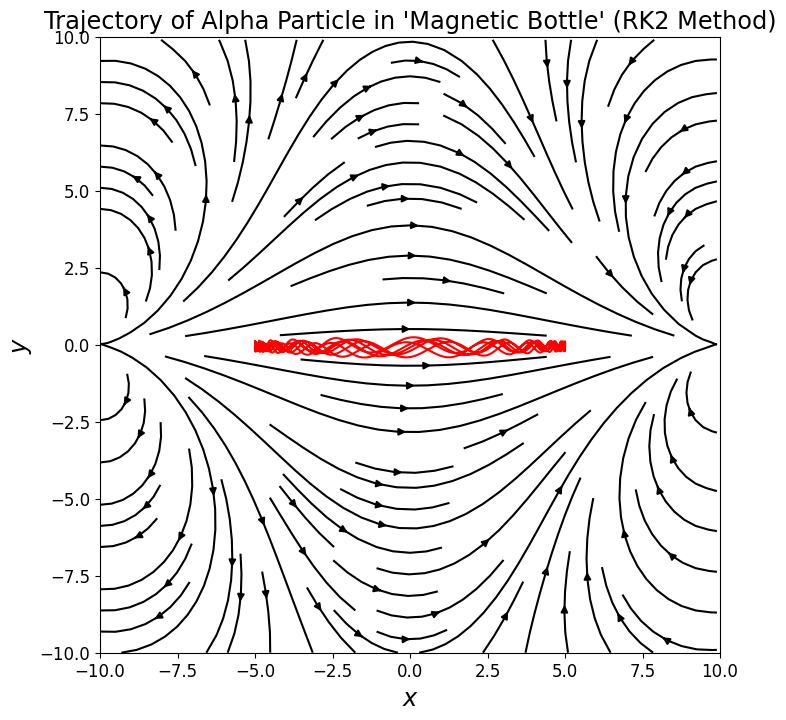

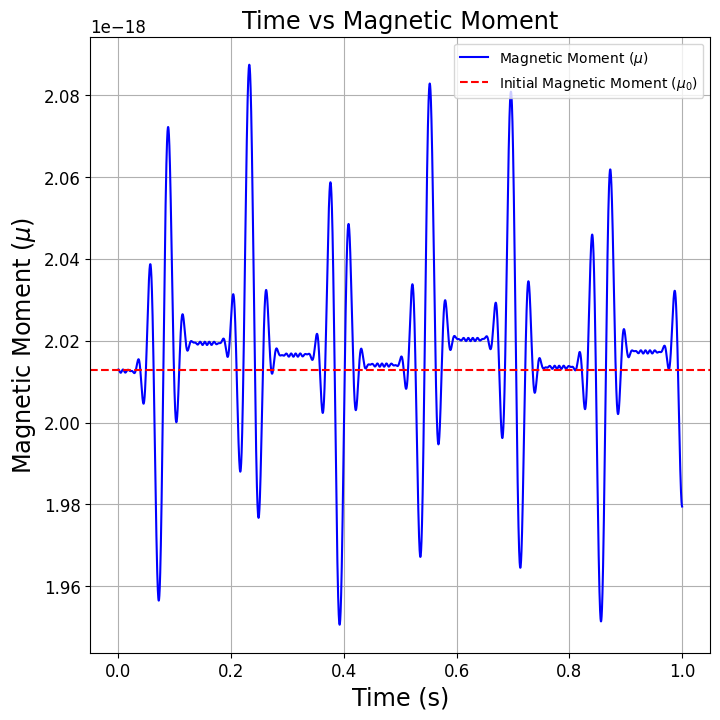

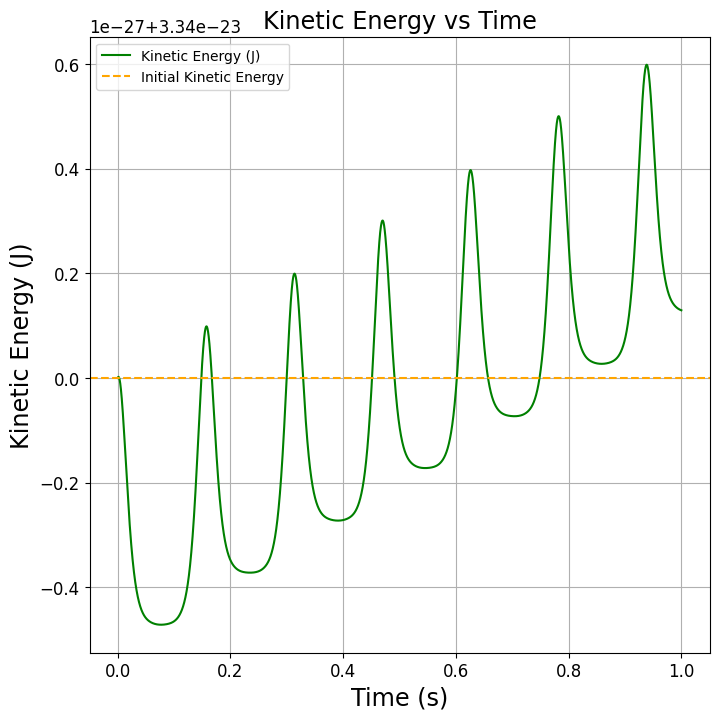

In [ ]:
import numpy
import matplotlib.pyplot as mpl
from numba import jit

# font size of x axis tick label, y axis tick label, x axis label, y axis label, title and figure size
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

# Value of constants (mass of proton(kg), charge of proton(C), permeability of free space(H/m), magnetic moment(J/T))
m_p = 1.67E-27
qe = 1.602E-19
mu0 = numpy.pi * 4.0E-7
mu = 10000.0 * numpy.array([1.0, 0.0, 0.0])  # along x axis

@jit # Just-in-Time compilation

## calculating magnetic field at a point (x,y,z)
def B_field(x, y, z):
    xdisp = 10.0  # Displacement

    # Point dipole A
    posA = numpy.array([xdisp, 0.0, 0.0]) # position vector of dipole A
    rA = numpy.array([x, y, z]) - posA # distance between the dipole A and the point where magnetic field to be calculated
    rmagA = numpy.linalg.norm(rA) # magnitude of the distance
    B1A = 3.0 * rA * numpy.dot(mu, rA) / (rmagA**5)
    B2A = -1.0 * mu / (rmagA**3)

    # Point dipole B
    posB = numpy.array([-xdisp, 0.0, 0.0]) # position vector of dipole B
    rB = numpy.array([x, y, z]) - posB # distance between the dipole B and the point where magnetic field to be calculated
    rmagB = numpy.linalg.norm(rB)
    B1B = 3.0 * rB * numpy.dot(mu, rB) / (rmagB**5)
    B2B = -1.0 * mu / (rmagB**3)

    return (mu0 / (4.0 * numpy.pi)) * (B1A + B2A + B1B + B2B) # formula for magnetic field due to both magnetic dipoles


@jit
def derivatives(r, v, QoverM):
    Bp = B_field(r[0], r[1], r[2]) # magnetic field
    Ap = QoverM * numpy.cross(v, Bp) # acceleration
    return Bp, Ap

@jit

def rk2_step(r, v, dt, QoverM):

    B1, a1 = derivatives(r, v, QoverM)
    # k1 for position and velocity update
    k1r = dt * v
    k1v = dt * a1

    # mid point position and velocity
    r_mid = r + 0.5 * k1r
    v_mid = v + 0.5 * k1v

    B2, a2 = derivatives(r_mid, v_mid, QoverM)
    # k2 for position and velocity update
    k2r = dt * v_mid
    k2v = dt * a2

    # position and velocity update
    r_new = r + k2r
    v_new = v + k2v
    return r_new, v_new

@jit
def parallel_perpendicular_components(v, B):
    B_hat = B / numpy.linalg.norm(B)
    v_parallel = (numpy.dot(v, B) / numpy.linalg.norm(B)) * B_hat
    v_perp = v - v_parallel
    magnetic_moment = (m * numpy.linalg.norm(v_perp)**2) / (2 * numpy.linalg.norm(B))
    return v_parallel, v_perp, magnetic_moment

## Creating a grid in XY plane
x = numpy.arange(-10.0, 10.0, 0.1)
y = numpy.arange(-10.0, 10.0, 0.1)
X, Y = numpy.meshgrid(x, y) # X(and Y) contains the x-coordinates(and y-coordinates) for all points in the grid
ilen, jlen = numpy.shape(X) # number of rows(ilen) and column(jlen) in X(same as Y)
Bf = numpy.zeros((ilen, jlen, 3)) # initializing 3D array (3 magnetic components)

for i in range(ilen):
    for j in range(jlen):
        Bf[i, j] = B_field(X[i, j], Y[i, j], 0.0) # magnetic field at each grid point

mpl.streamplot(X, Y, Bf[:, :, 0], Bf[:, :, 1], color="black") # streamplot of x and y component of magnetic field

## Particle motion parameters
m = 4.0 * m_p  # Mass of the alpha particle
q = 2.0 * qe  # Charge of the alpha particle
QoverM = q / m
dt = 1E-5  # Small time step (s)
t = numpy.arange(0.0, 1.0, dt)

rp = numpy.zeros((len(t), 3))  # Position array
vp = numpy.zeros((len(t), 3))  # Velocity array

## Initial conditions
rp[0, :] = numpy.array([-5.0, 0.0, 0.0])  # Start from x = -5
vp[0, :] = numpy.array([0.0, 100.0, 0.0])  # Initial velocity along y axis

# Initialize array to store magnetic moment
mu_particle = numpy.zeros(len(t))

# Initialize array to store energy
energy = numpy.zeros(len(t))
energy[0] = 0.5 * m * numpy.linalg.norm(vp[0, :])**2  # Initial kinetic energy

# initial values
B0 = B_field(rp[0, 0], rp[0, 1], rp[0, 2])
v0_parallel_vec, v0_perp_vec, mu0_particle = parallel_perpendicular_components(vp[0, :], B0)

## RK2 method
for it in range(len(t) - 1):
    #Bp = B_field(rp[it, 0], rp[it, 1], rp[it, 2]) # magnetic field at particle's current position
    Bp,Ap = derivatives(rp[it], vp[it], QoverM)
    v_parallel, v_perp, mu_particle[it] = parallel_perpendicular_components(vp[it, :], Bp)
    # Calculate kinetic energy
    energy[it] = 0.5 * m * numpy.linalg.norm(vp[it, :])**2
    rp[it + 1], vp[it + 1] = rk2_step(rp[it], vp[it], dt, QoverM)
    if numpy.linalg.norm(rp[it + 1]) > 20.0:
        break  # Stop if the particle escapes

t = t[:it+1]
mu_particles = mu_particle[:it+1]
energy = energy[:it+1]

# Ploting the trajectory
mpl.plot(rp[:, 0], rp[:, 1], color='red')
mpl.xlim(-10.0, 10.0)
mpl.ylim(-10.0, 10.0)
mpl.xlabel("$x$")
mpl.ylabel("$y$")
mpl.title("Trajectory of Alpha Particle in 'Magnetic Bottle' (RK2 Method)")
mpl.show()

# Plot the magnetic moment over time
mpl.plot(t, mu_particles, color='blue', label='Magnetic Moment ($\mu$)')
mpl.axhline(mu0_particle, color='red', linestyle='--', label='Initial Magnetic Moment ($\mu_0$)')
mpl.xlabel('Time (s)')
mpl.ylabel('Magnetic Moment ($\mu$)')
mpl.title('Time vs Magnetic Moment')
mpl.legend()
mpl.grid(True)
mpl.show()

# Plot the energy over time
mpl.plot(t, energy, color='green', label='Kinetic Energy (J)')
mpl.axhline(energy[0], color='orange', linestyle='--', label='Initial Kinetic Energy')
mpl.xlabel('Time (s)')
mpl.ylabel('Kinetic Energy (J)')
mpl.title('Kinetic Energy vs Time')
mpl.legend()
mpl.grid(True)
mpl.show()


# Particle Motion in a Magnetic Mirror

This notebook simulates the trajectory of a charged particle in a magnetic
mirror configuration formed by two magnetic dipoles.

**Numerical Method:** RK4 Method

**Quantities analyzed:**
- Particle trajectory
- Magnetic moment
- Kinetic energy


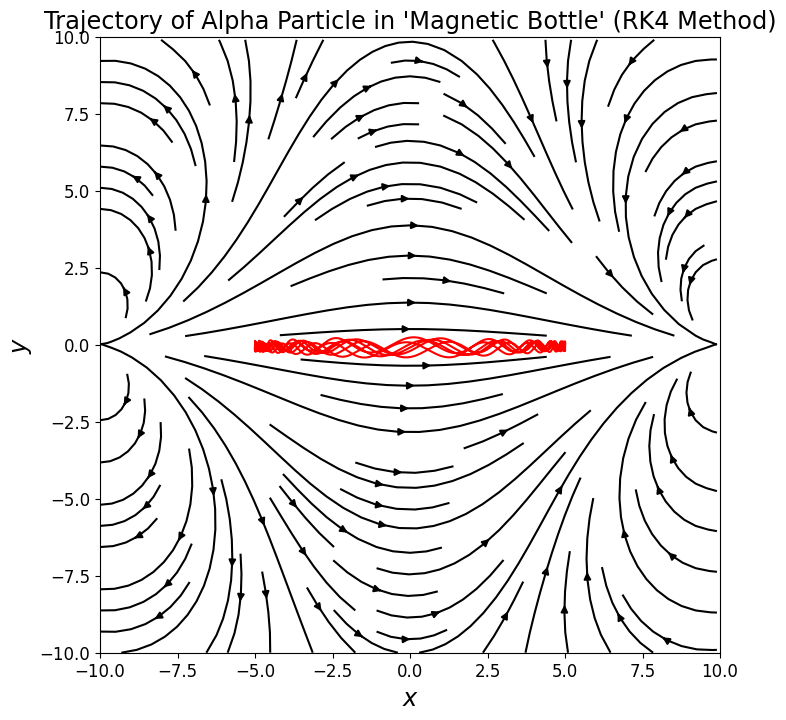

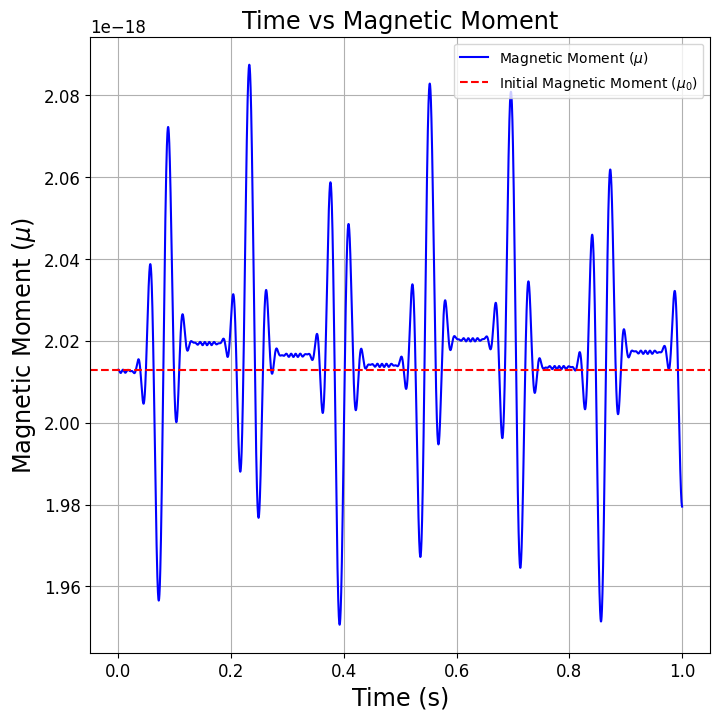

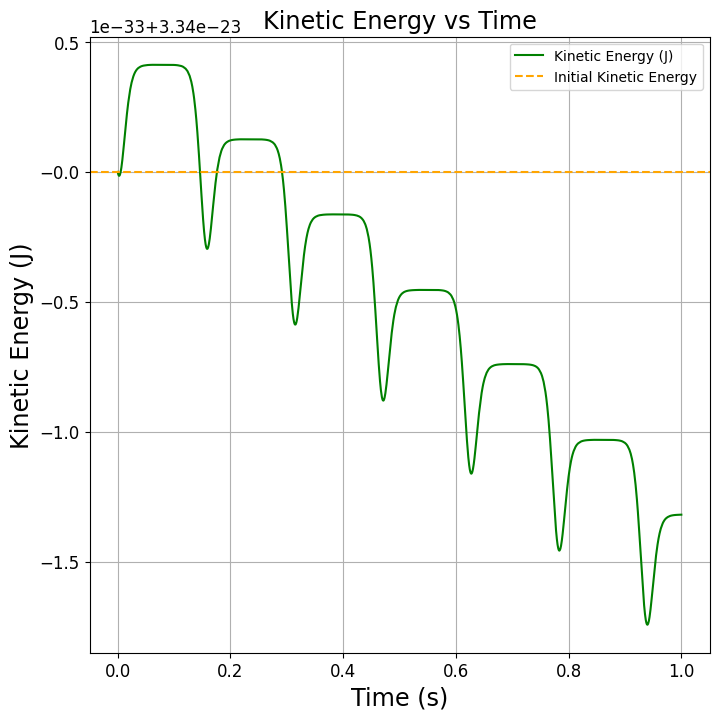

In [ ]:
import numpy
import matplotlib.pyplot as mpl
from numba import jit

# font size of x axis tick label, y axis tick label, x axis label, y axis label, title and figure size
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

# Value of constants (mass of proton(kg), charge of proton(C), permeability of free space(H/m), magnetic moment(J/T))
m_p = 1.67E-27
qe = 1.602E-19
mu0 = numpy.pi * 4.0E-7
mu = 10000.0 * numpy.array([1.0, 0.0, 0.0])  # along x axis

@jit # Just-in-Time compilation

## calculating magnetic field at a point (x,y,z)
def B_field(x, y, z):
    xdisp = 10.0  # Displacement

    # Point dipole A
    posA = numpy.array([xdisp, 0.0, 0.0]) # position vector of dipole A
    rA = numpy.array([x, y, z]) - posA # distance between the dipole A and the point where magnetic field to be calculated
    rmagA = numpy.linalg.norm(rA) # magnitude of the distance
    B1A = 3.0 * rA * numpy.dot(mu, rA) / (rmagA**5)
    B2A = -1.0 * mu / (rmagA**3)

    # Point dipole B
    posB = numpy.array([-xdisp, 0.0, 0.0]) # position vector of dipole B
    rB = numpy.array([x, y, z]) - posB # distance between the dipole B and the point where magnetic field to be calculated
    rmagB = numpy.linalg.norm(rB)
    B1B = 3.0 * rB * numpy.dot(mu, rB) / (rmagB**5)
    B2B = -1.0 * mu / (rmagB**3)

    return (mu0 / (4.0 * numpy.pi)) * (B1A + B2A + B1B + B2B) # formula for magnetic field due to both magnetic dipoles

@jit
def derivatives(r, v, QoverM):
    Bp = B_field(r[0], r[1], r[2]) # magnetic field
    Ap = QoverM * np.cross(v, Bp) # acceleration
    return Bp, Ap

# RK4 method to solve motion equations
def RK4_step(r, v, dt, QoverM):
    B1, a1 = derivatives(r, v, QoverM)
    # k1 for position and velocity update
    k1r = dt * v
    k1v = dt * a1

    B2, a2 = derivatives(r + 0.5 * k1r, v + 0.5 * k1v, QoverM)
    # k2 for position and velocity update
    k2r = dt * (v + 0.5 * k1v)
    k2v = dt * a2

    B3, a3 = derivatives(r + 0.5 * k2r, v + 0.5 * k2v, QoverM)
    # k3 for position and velocity update
    k3r = dt * (v + 0.5 * k2v)
    k3v = dt * a3

    B4, a4 = derivatives(r + k3r, v + k3v, QoverM)
    # k4 for position and velocity update
    k4r = dt * (v + k3v)
    k4v = dt * a4

    r_new = r + (k1r + 2 * k2r + 2 * k3r + k4r) / 6
    v_new = v + (k1v + 2 * k2v + 2 * k3v + k4v) / 6

    return r_new, v_new

@jit
def parallel_perpendicular_components(v, B):
    B_hat = B / numpy.linalg.norm(B)
    v_parallel = numpy.dot(v, B_hat) * B_hat
    v_perp = v - v_parallel
    magnetic_moment = (m * numpy.linalg.norm(v_perp)**2) / (2 * numpy.linalg.norm(B))
    return v_parallel, v_perp, magnetic_moment

## Creating a grid in XY plane
x = numpy.arange(-10.0, 10.0, 0.1)
y = numpy.arange(-10.0, 10.0, 0.1)
X, Y = numpy.meshgrid(x, y) # X(and Y) contains the x-coordinates(and y-coordinates) for all points in the grid
ilen, jlen = numpy.shape(X) # number of rows(ilen) and column(jlen) in X(same as Y)
Bf = numpy.zeros((ilen, jlen, 3)) # initializing 3D array (3 magnetic components)

for i in range(ilen):
    for j in range(jlen):
        Bf[i, j] = B_field(X[i, j], Y[i, j], 0.0) # magnetic field at each grid point

mpl.streamplot(X, Y, Bf[:, :, 0], Bf[:, :, 1], color="black") # streamplot of x and y component of magnetic field

## Particle motion parameters
m = 4.0 * m_p  # Mass of the alpha particle
q = 2.0 * qe  # Charge of the alpha particle
QoverM = q / m
dt = 1E-5  # Small time step (s)
t = numpy.arange(0.0, 1.0, dt)

rp = numpy.zeros((len(t), 3))  # Position array
vp = numpy.zeros((len(t), 3))  # Velocity array

## Initial conditions
rp[0, :] = numpy.array([-5.0, 0.0, 0.0])  # Start from x = -5
vp[0, :] = numpy.array([0.0, 100.0, 0.0])  # Initial velocity along y axis

# Initialize array to store magnetic moment
mu_particle = numpy.zeros(len(t))

# Initialize array to store energy
energy = numpy.zeros(len(t))
energy[0] = 0.5 * m * numpy.linalg.norm(vp[0, :])**2  # Initial kinetic energy

# initial values
B0 = B_field(rp[0, 0], rp[0, 1], rp[0, 2])
v0_parallel_vec, v0_perp_vec, mu0_particle = parallel_perpendicular_components(vp[0, :], B0)

## RK4 method
for it in range(len(t) - 1):
    Bp, Ap = derivatives(rp[it], vp[it], QoverM)
    v_parallel, v_perp, mu_particle[it] = parallel_perpendicular_components(vp[it, :], Bp)
    # Calculate kinetic energy
    energy[it] = 0.5 * m * numpy.linalg.norm(vp[it, :])**2
    rp[it + 1], vp[it + 1] = RK4_step(rp[it], vp[it], dt, QoverM)
    if np.linalg.norm(rp[it + 1]) > 20.0:
        break  # Stop if the particle escapes

t = t[:it+1]
mu_particles = mu_particle[:it+1]
energy = energy[:it+1]

# Ploting the trajectory
mpl.plot(rp[:, 0], rp[:, 1], color='red')
mpl.xlim(-10.0, 10.0)
mpl.ylim(-10.0, 10.0)
mpl.xlabel("$x$")
mpl.ylabel("$y$")
mpl.title("Trajectory of Alpha Particle in 'Magnetic Bottle' (RK4 Method)")
mpl.show()

# Plot the magnetic moment over time
mpl.plot(t, mu_particles, color='blue', label='Magnetic Moment ($\mu$)')
mpl.axhline(mu0_particle, color='red', linestyle='--', label='Initial Magnetic Moment ($\mu_0$)')
mpl.xlabel('Time (s)')
mpl.ylabel('Magnetic Moment ($\mu$)')
mpl.title('Time vs Magnetic Moment')
mpl.legend()
mpl.grid(True)
mpl.show()

# Plot the energy over time
mpl.plot(t, energy, color='green', label='Kinetic Energy (J)')
mpl.axhline(energy[0], color='orange', linestyle='--', label='Initial Kinetic Energy')
mpl.xlabel('Time (s)')
mpl.ylabel('Kinetic Energy (J)')
mpl.title('Kinetic Energy vs Time')
mpl.legend()
mpl.grid(True)
mpl.show()


# Particle Motion in a Magnetic Mirror

This notebook simulates the trajectory of a charged particle in a magnetic
mirror configuration formed by two magnetic dipoles.

**Numerical Method:** Boris Scheme

**Quantities analyzed:**
- Particle trajectory
- Magnetic moment
- Kinetic energy


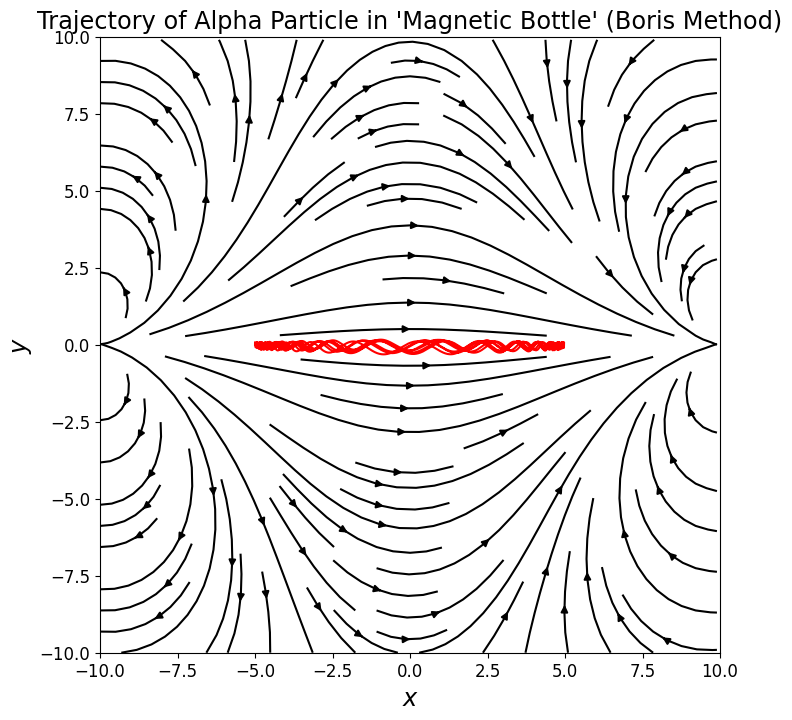

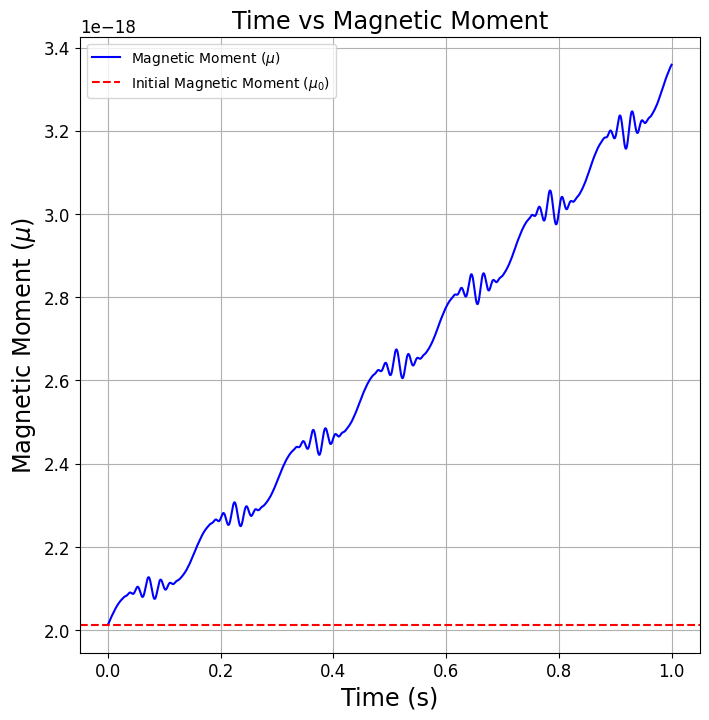

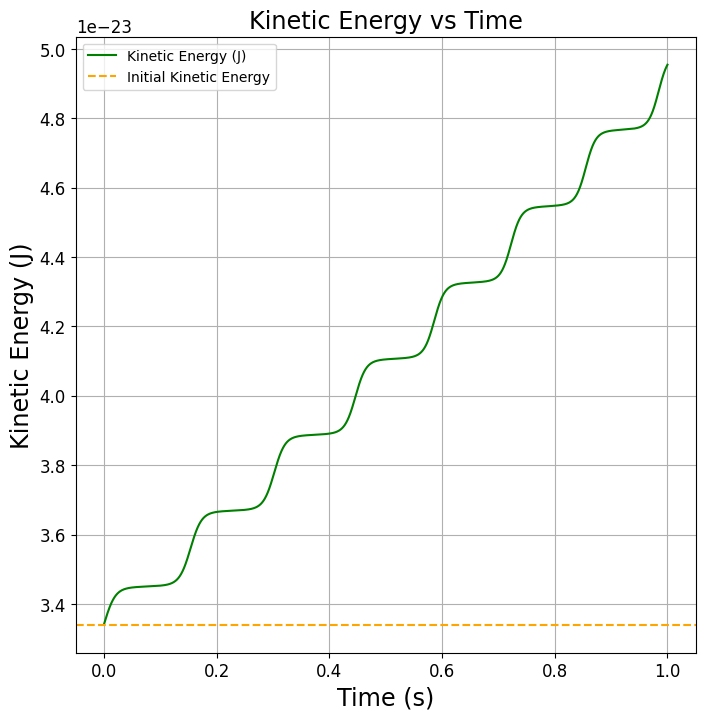

In [ ]:
import numpy
import matplotlib.pyplot as mpl
from numba import jit

# font size of x axis tick label, y axis tick label, x axis label, y axis label, title and figure size
mpl.rc("xtick", labelsize="large")
mpl.rc("ytick", labelsize="large")
mpl.rc("axes", labelsize="xx-large")
mpl.rc("axes", titlesize="xx-large")
mpl.rc("figure", figsize=(8,8))

# Value of constants (mass of proton(kg), charge of proton(C), permeability of free space(H/m), magnetic moment(J/T))
m_p = 1.67E-27
qe = 1.602E-19
mu0 = numpy.pi * 4.0E-7
mu = 10000.0 * numpy.array([1.0, 0.0, 0.0])  # along x axis

@jit # Just-in-Time compilation

## calculating magnetic field at a point (x,y,z)
def B_field(x, y, z):
    xdisp = 10.0  # Displacement

    # Point dipole A
    posA = numpy.array([xdisp, 0.0, 0.0]) # position vector of dipole A
    rA = numpy.array([x, y, z]) - posA # distance between the dipole A and the point where magnetic field to be calculated
    rmagA = numpy.linalg.norm(rA) # magnitude of the distance
    B1A = 3.0 * rA * numpy.dot(mu, rA) / (rmagA**5)
    B2A = -1.0 * mu / (rmagA**3)

    # Point dipole B
    posB = numpy.array([-xdisp, 0.0, 0.0]) # position vector of dipole B
    rB = numpy.array([x, y, z]) - posB # distance between the dipole B and the point where magnetic field to be calculated
    rmagB = numpy.linalg.norm(rB)
    B1B = 3.0 * rB * numpy.dot(mu, rB) / (rmagB**5)
    B2B = -1.0 * mu / (rmagB**3)

    return (mu0 / (4.0 * numpy.pi)) * (B1A + B2A + B1B + B2B) # formula for magnetic field due to both magnetic dipoles

@jit

# Boris scheme for solving motion equations
def boris_step(r, v, dt):
    Bp = B_field(r[0], r[1], r[2])  # Magnetic field at current position

    # Half-step velocity update
    v_half = v + (QoverM) * numpy.cross(v, Bp) * (dt/2)

    # Rotation using t and s vectors
    t = (q / m) * Bp * (dt / 2) # scaled rotation factor
    s = 2 * t / (1 + numpy.dot(t, t)) # correction term for the rotation

    v_prime = v_half + numpy.cross(v_half, t)  # Intermediate velocity
    v_new = v_half + numpy.cross(v_prime, s)  # Final velocity update

    # Full-step position update
    r_new = r + v_new * dt

    return r_new, v_new

def parallel_perpendicular_components(v, B):
    B_hat = B / numpy.linalg.norm(B)
    v_parallel = (numpy.dot(v, B) / numpy.linalg.norm(B)) * B_hat
    v_perp = v - v_parallel
    magnetic_moment = (m * numpy.linalg.norm(v_perp)**2) / (2 * numpy.linalg.norm(B))
    return v_parallel, v_perp, magnetic_moment

## Creating a grid in XY plane
x = numpy.arange(-10.0, 10.0, 0.1)
y = numpy.arange(-10.0, 10.0, 0.1)
X, Y = numpy.meshgrid(x, y) # X(and Y) contains the x-coordinates(and y-coordinates) for all points in the grid
ilen, jlen = numpy.shape(X) # number of rows(ilen) and column(jlen) in X(same as Y)
Bf = numpy.zeros((ilen, jlen, 3)) # initializing 3D array (3 magnetic components)

for i in range(ilen):
    for j in range(jlen):
        Bf[i, j] = B_field(X[i, j], Y[i, j], 0.0) # magnetic field at each grid point

mpl.streamplot(X, Y, Bf[:, :, 0], Bf[:, :, 1], color="black") # streamplot of x and y component of magnetic field

## Particle motion parameters
m = 4.0 * m_p  # Mass of the alpha particle
q = 2.0 * qe  # Charge of the alpha particle
QoverM = q / m
dt = 1E-5  # Small time step (s)
t = numpy.arange(0.0, 1.0, dt)

rp = numpy.zeros((len(t), 3))  # Position array
vp = numpy.zeros((len(t), 3))  # Velocity array

## Initial conditions
rp[0, :] = numpy.array([-5.0, 0.0, 0.0])  # Start from x = -5
vp[0, :] = numpy.array([0.0, 100.0, 0.0])  # Initial velocity along y axis

# Initialize array to store magnetic moment
mu_particle = numpy.zeros(len(t))

# Initialize array to store energy
energy = numpy.zeros(len(t))
energy[0] = 0.5 * m * numpy.linalg.norm(vp[0, :])**2  # Initial kinetic energy

# initial values
B0 = B_field(rp[0, 0], rp[0, 1], rp[0, 2])
v0_parallel_vec, v0_perp_vec, mu0_particle = parallel_perpendicular_components(vp[0, :], B0)


## Boris scheme
for it in range(len(t) - 1):
    Bp = B_field(rp[it, 0], rp[it, 1], rp[it, 2])
    v_parallel, v_perp, mu_particle[it] = parallel_perpendicular_components(vp[it, :], Bp)
    # Calculate kinetic energy
    energy[it] = 0.5 * m * numpy.linalg.norm(vp[it, :])**2
    rp[it + 1], vp[it + 1] = boris_step(rp[it], vp[it], dt)
    if numpy.sqrt(numpy.sum(rp[it + 1] ** 2)) > 20.0:  # Stop if particle escapes
        rp = rp[:i+1]  # Trim trajectory
        break

t = t[:it+1]
mu_particles = mu_particle[:it+1]
energy = energy[:it+1]

# Ploting the trajectory
mpl.plot(rp[:, 0], rp[:, 1], color='red')
mpl.xlim(-10.0, 10.0)
mpl.ylim(-10.0, 10.0)
mpl.xlabel("$x$")
mpl.ylabel("$y$")
mpl.title("Trajectory of Alpha Particle in 'Magnetic Bottle' (Boris Method)")
mpl.show()

# Plot of magnetic moment over time
mpl.plot(t, mu_particles, color='blue', label='Magnetic Moment ($\mu$)')
mpl.axhline(mu0_particle, color='red', linestyle='--', label='Initial Magnetic Moment ($\mu_0$)')
mpl.xlabel('Time (s)')
mpl.ylabel('Magnetic Moment ($\mu$)')
mpl.title('Time vs Magnetic Moment')
mpl.legend()
mpl.grid(True)
mpl.show()

# Plot of Kinetic energy over time
mpl.plot(t, energy, color='green', label='Kinetic Energy (J)')
mpl.axhline(energy[0], color='orange', linestyle='--', label='Initial Kinetic Energy')
mpl.xlabel('Time (s)')
mpl.ylabel('Kinetic Energy (J)')
mpl.title('Kinetic Energy vs Time')
mpl.legend()
mpl.grid(True)
mpl.show()


########################################################